In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
import arviz as az  # ArviZ is useful for MCMC diagnostics
import matplotlib.pyplot as plt
import arviz as az

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(False)

# set matplotlib plotting style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# set device for all tensors
device = 'cuda'

In [5]:
# Load in mcmc data sets

# load in the data
numerical_reader = emcee.backends.HDFBackend('mcmc/76walkers_chain_outputs.h5', read_only=True)
pretrain_reader = emcee.backends.HDFBackend('mcmc/76_pretrain_emulator_mcmc_samples.h5', read_only=True)
fresh_reader = emcee.backends.HDFBackend('mcmc/76_fresh_emulator_mcmc_samples.h5', read_only=True)
maml_reader = emcee.backends.HDFBackend('mcmc/76_maml_emulator_mcmc_samples.h5', read_only=True)

# # Save numerical data to new file without blobs
# numerical_chain = numerical_reader.get_chain()
# numerical_log_prob = numerical_reader.get_log_prob()
# numerical_acceptance = numerical_reader.get_blobs()
# fname = 'mcmc/76walkers_chain_outputs_no_blobs.h5'
# with h5.File(fname, 'w') as f:
#     f.create_dataset('chain', data=numerical_chain)
#     f.create_dataset('log_prob', data=numerical_log_prob)
#     f.create_dataset('acceptance', data=numerical_acceptance)

In [6]:
# Print max autocorr length
print('Numerical max autocorr length:', np.max(numerical_reader.get_autocorr_time()))
print('Pretrain max autocorr length:', np.max(pretrain_reader.get_autocorr_time()))
print('Fresh max autocorr length:', np.max(fresh_reader.get_autocorr_time()))
print('MAML max autocorr length:', np.max(maml_reader.get_autocorr_time()))

Numerical max autocorr length: 336.76557547468536
Pretrain max autocorr length: 637.5516535955325
Fresh max autocorr length: 581.9635065613069
MAML max autocorr length: 530.2750350697918


In [7]:
def calculate_ESS(reader):
    tau = reader.get_autocorr_time()
    n_walkers, n_samples, n_dim = reader.get_chain().shape
    ess = (n_samples * n_walkers) / (1 + 2 * np.sum(tau))
    return ess

print('Numerical ESS:', calculate_ESS(numerical_reader))
print('Pretrain ESS:', calculate_ESS(pretrain_reader))
print('Fresh ESS:', calculate_ESS(fresh_reader))
print('MAML ESS:', calculate_ESS(maml_reader))

Numerical ESS: 216.96225870447554
Pretrain ESS: 510.566196902199
Fresh ESS: 506.8472627234054
MAML ESS: 483.76138445902444


In [8]:
numerical_samples = numerical_reader.get_chain(discard=2000, flat=True)[:,:5]
pretrain_samples = pretrain_reader.get_chain(discard=2000, flat=True)[:,:5]
fresh_samples = fresh_reader.get_chain(discard=2000, flat=True)[:,:5]
maml_samples = maml_reader.get_chain(discard=2000, flat=True)[:,:5]

# Compute Rhat
num_rhat = az.rhat(numerical_samples)
pretrain_rhat = az.rhat(pretrain_samples)
fresh_rhat = az.rhat(fresh_samples)
maml_rhat = az.rhat(maml_samples)

print('Numerical Rhat:', num_rhat)
print('Pretrain Rhat:', pretrain_rhat)
print('Fresh Rhat:', fresh_rhat)
print('MAML Rhat:', maml_rhat)

Numerical Rhat: 1.2686649254818512
Pretrain Rhat: 1.2679919463520726
Fresh Rhat: 1.2843628912726968
MAML Rhat: 1.27006386764462


In [9]:
# Combine Omega_c and Omega_b to Omega_m
Omega_m = numerical_samples[:,0] + numerical_samples[:,1]
numerical_samples = np.concatenate((Omega_m[:,None], numerical_samples[:,2:]), axis=1)

Omega_m = pretrain_samples[:,0] + pretrain_samples[:,1]
pretrain_samples = np.concatenate((Omega_m[:,None], pretrain_samples[:,2:]), axis=1)

Omega_m = fresh_samples[:,0] + fresh_samples[:,1]
fresh_samples = np.concatenate((Omega_m[:,None], fresh_samples[:,2:]), axis=1)

Omega_m = maml_samples[:,0] + maml_samples[:,1]
maml_samples = np.concatenate((Omega_m[:,None], maml_samples[:,2:]), axis=1)

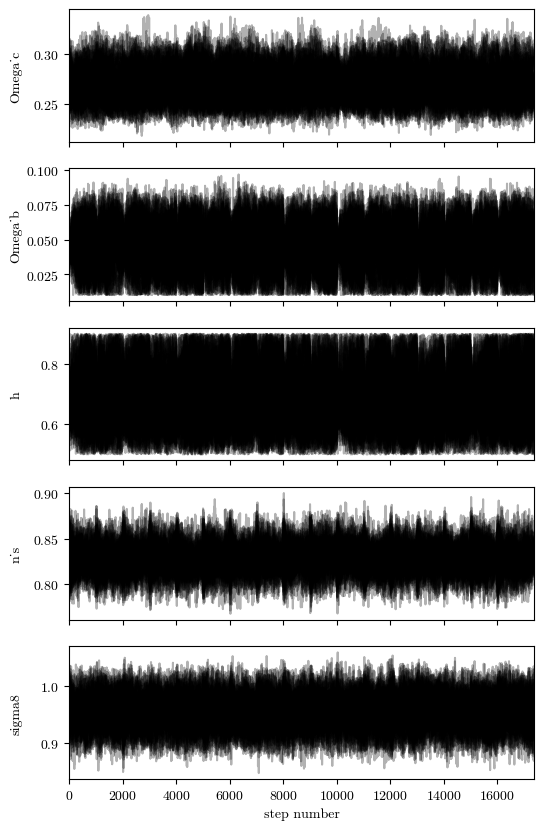

In [10]:
# Plot chains from MAML
fig, axes = plt.subplots(5, 1, figsize=(6, 10), sharex=True)
samples = numerical_reader.get_chain()
labels = ["Omega_c", "Omega_b", "h", "n_s", "sigma8"]
for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

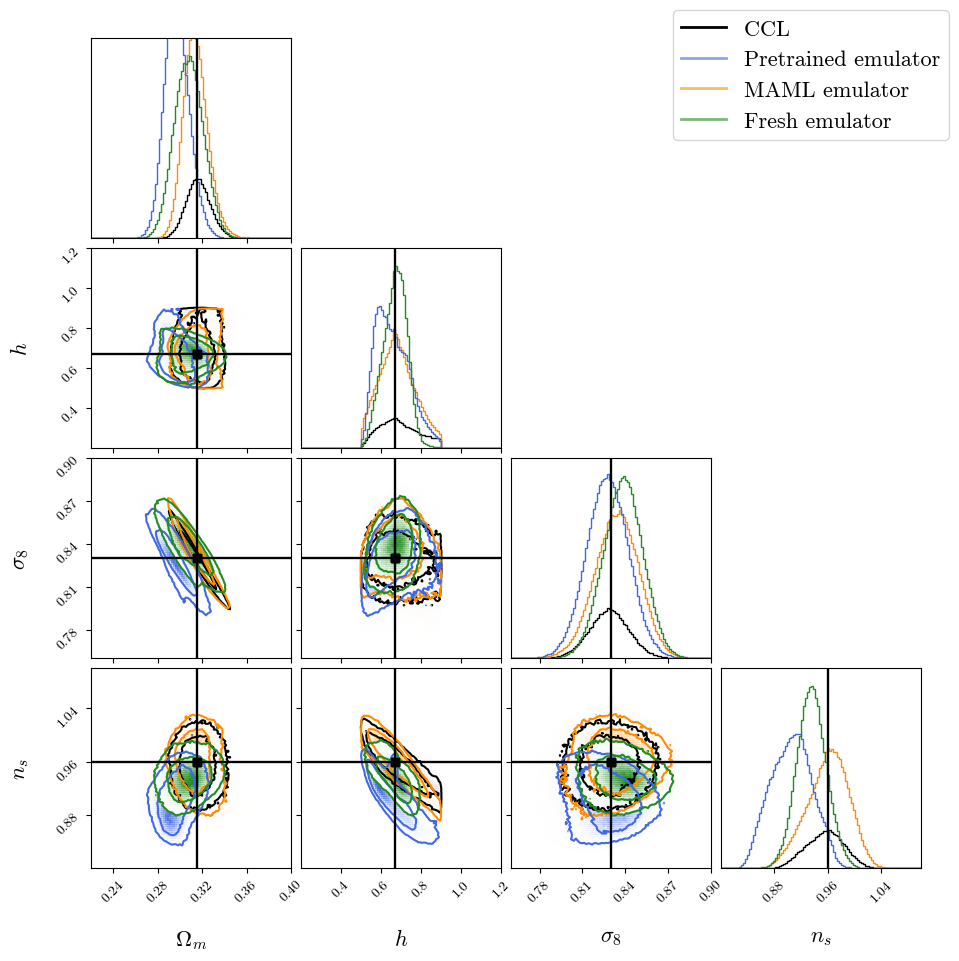

In [12]:

theta_fid = np.array([0.27+0.045, 0.67, 0.83, 0.96])
param_ranges = [(0.22, 0.4), (0.2, 1.2), (0.76, 0.9), (0.8, 1.1)]
smooth = 0.05
bins = 100

labels = [r"$\Omega_m$", r"$h$", r"$\sigma_8$", r"$n_s$", r"$\delta^z_1$", r"$\delta^z_2$", ]
# Plot the corner plot
fig = corner.corner(
    numerical_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color='k',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    range=param_ranges,
    label_kwargs={'fontsize': 16}
)

# Add MAML samples
corner.corner(
    maml_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color='darkorange',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    range=param_ranges,
    fig=fig
)

# Add emulator samples
corner.corner(
    pretrain_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color='royalblue',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    range=param_ranges,
    fig=fig
)

# Add fresh samples
corner.corner(
    fresh_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=[0.68, 0.95],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color='forestgreen',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    range=param_ranges,
    fig=fig
)

handles = [
    plt.Line2D([0], [0], color='k', lw=2, alpha=1, label='CCL '),
    plt.Line2D([0], [0], color='royalblue', lw=2, alpha=0.6, label='Pretrained emulator'),
    plt.Line2D([0], [0], color='darkorange', lw=2, alpha=0.6, label='MAML emulator'),
    plt.Line2D([0], [0], color='forestgreen', lw=2, alpha=0.6, label='Fresh emulator')
]

fig.legend(handles=handles, loc='upper right', fontsize=16)
plt.savefig('mcmc/mcmc_compare_emulators.pdf', bbox_inches='tight', dpi=300)

- Remove lines in 1D distributions (but keep truth line)
- Make tick labels and axis labels bigger
- Try using unfilled contours
- Try using just unfilled for non-MAML

In [ ]:
import numpy as np
import scipy.stats as stats

def compute_summary_stats(samples_emul, samples_fid, theta_fid):
    """
    Compute summary statistics comparing emulator MCMC posterior to fully computed posterior.

    Parameters:
    - samples_emul: (n_samples, n_params) array of emulator posterior samples
    - samples_fid: (n_samples, n_params) array of fiducial posterior samples
    - theta_fid: (n_params,) array of fiducial parameter values

    Returns:
    - Dictionary with bias, standard deviation ratio, posterior volume ratio, credible interval overlap, and KL divergence.
    """
    
    # Compute means and standard deviations
    theta_emul_mean = np.mean(samples_emul, axis=0)
    theta_fid_mean = np.mean(samples_fid, axis=0)

    sigma_emul = np.std(samples_emul, axis=0, ddof=1)
    sigma_fid = np.std(samples_fid, axis=0, ddof=1)

    # Compute bias metrics
    bias = theta_emul_mean - theta_fid
    relative_bias = bias / sigma_fid  # Relative to fiducial uncertainty

    # Compute constraining power metrics
    sigma_ratio = sigma_emul / sigma_fid  # Ratio of standard deviations
    posterior_volume_ratio = np.prod(sigma_ratio)  # Multidimensional volume ratio

    # Compute credible interval overlap (assumes Gaussian approximation)
    overlap = np.mean((theta_fid > (theta_emul_mean - sigma_emul)) & 
                      (theta_fid < (theta_emul_mean + sigma_emul)))

    # Compute KL divergence
    kl_div = np.sum(stats.gaussian_kde(samples_emul.T).logpdf(samples_fid.T) - 
                    stats.gaussian_kde(samples_fid.T).logpdf(samples_fid.T))

    return {
        "bias": bias,
        "relative_bias": relative_bias,
        "sigma_ratio": sigma_ratio,
        "posterior_volume_ratio": posterior_volume_ratio,
        "credible_interval_overlap": overlap,
        "KL_divergence": kl_div
    }

# Example usage
# Assume `samples_emul` and `samples_fid` are loaded from MCMC chains

results = compute_summary_stats(maml_samples, numerical_samples, theta_fid)
print(results)

results = compute_summary_stats(pretrain_samples, numerical_samples, theta_fid)
print(results)

{'bias': array([-0.00116945,  0.00723053,  0.00405645,  0.00036743]), 'relative_bias': array([-0.1060425 ,  0.07441799,  0.29167332,  0.01294835]), 'sigma_ratio': array([1.01760271, 0.91453213, 1.12492657, 1.09622855]), 'posterior_volume_ratio': 1.1476316223754492, 'credible_interval_overlap': 1.0, 'KL_divergence': -9491.866525711579}
{'bias': array([-0.0177909 , -0.01174844, -0.00284811, -0.0554336 ]), 'relative_bias': array([-1.61322633, -0.12091717, -0.2047896 , -1.95349806]), 'sigma_ratio': array([1.02149149, 0.85217391, 1.06562314, 1.04001877]), 'posterior_volume_ratio': 0.9647344878368751, 'credible_interval_overlap': 0.5, 'KL_divergence': -111484.29558096602}
